<a href="https://colab.research.google.com/github/CamiloVga/Curso-IA-Aplicada/blob/main/Script_Clase_28_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 Inteligencia Artificial Aplicada
## Universidad de los Andes

### 👨‍🏫 Profesores
- **Profesor Magistral:** [Camilo Vega Barbosa](https://www.linkedin.com/in/camilovegabarbosa/)
- **Asistente de Docencia:** [Sergio Julian Zona Moreno](https://www.linkedin.com/in/sergiozonamoreno/)

### 📚 Fine-Tuning con PEFT-LoRA para Modelos de Lenguaje
Este script implementa un proceso de fine-tuning eficiente para modelos de lenguaje:

1. **Configuración del Modelo y Datos 🚀**
   - Uso de Microsoft Phi-2, un modelo de 2.7B de parámetros con alta capacidad
   - Carga de datos especializados para aprender el "idioma 4" (reemplazar "a" por "4")
   - Preparación eficiente de tokens y formato de instrucción

2. **Implementación de PEFT-LoRA 🧠**
   - Parameter-Efficient Fine-Tuning (PEFT) con Low-Rank Adaptation (LoRA)
   - Modificación selectiva de solo ~1% de los parámetros del modelo
   - Enfoque en capas estratégicas: q_proj, k_proj, v_proj, o_proj, fc1, fc2
   - Cuantización de 8-bits para reducción drástica de memoria requerida

3. **Proceso de Entrenamiento Optimizado 📈**
   - Configuración para entrenamiento rápido inicial y opciones para profundizar
   - Monitoreo de la función de pérdida con visualización gráfica
   - Balance entre velocidad y precisión mediante hiperparámetros adaptables
   - Guardado eficiente del modelo adaptado para su uso posterior

4. **Inferencia y Aplicación 🔍**
   - Generación de texto traducido al "idioma 4"
   - Parámetros de muestreo para control de creatividad vs. precisión
   - Evaluación con casos de prueba específicos para verificar aprendizaje



In [1]:
# Instalamos las bibliotecas necesarias
!pip install -q transformers datasets peft bitsandbytes accelerate gradio

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# 1. CARGA DE DATOS
# Descargamos los datos directamente desde el repositorio de GitHub
# Definimos la ruta al archivo CSV en tu repositorio
github_repo = "CamiloVga/Curso-IA-Aplicada"
branch = "main"
file_path = "Semana 14_Fine-Tuning y RAG/Base Fine-Tuning Idioma 4.csv"

# Cargamos el dataset desde GitHub
print("Cargando dataset desde GitHub...")
dataset = load_dataset("csv",
                      data_files=f"https://raw.githubusercontent.com/{github_repo}/{branch}/{file_path}")

# Exploramos el dataset
print("Estructura del dataset:")
print(dataset)
print("\nEjemplo de entrada:")
print(dataset["train"][0])
print(f"Número de ejemplos: {len(dataset['train'])}")

# 2. PREPROCESAMIENTO DE DATOS
# Phi-2 es un modelo más pequeño (2.7B) pero de alto rendimiento y acceso abierto
model_name = "microsoft/phi-2"

print(f"Cargando tokenizador para {model_name}...")
# Cargamos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Aseguramos que el tokenizador tenga tokens especiales necesarios
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Definimos una función para preprocesar los datos
def preprocess_function(examples):
    # Formateamos los textos como instrucciones siguiendo un formato tipo chat
    prompts = []
    for i in range(len(examples["input"])):
        # Formato de instrucción para Phi-2
        prompt = f"<s>Traduce este texto al idioma 4: {examples['input'][i]}\n\n{examples['output'][i]}</s>"
        prompts.append(prompt)

    # Tokenizamos los textos
    tokenized_inputs = tokenizer(
        prompts,
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )

    # Configuramos las labels igual que los input_ids para entrenamiento de LM causal
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].clone()

    return tokenized_inputs

# Aplicamos la función de preprocesamiento al dataset
print("Procesando y tokenizando el dataset...")
tokenized_dataset = dataset["train"].map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

print(f"Dataset tokenizado: {tokenized_dataset}")

# 3. CONFIGURACIÓN DEL MODELO
# Configuramos BitsAndBytes para cuantización de 8 bits (ahorra memoria)
print("Configurando cuantización para el modelo...")
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Phi-2 funciona bien con cuantización de 8 bits
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf4",
    bnb_8bit_compute_dtype=torch.float16
)

# Cargamos el modelo base con cuantización
print(f"Cargando modelo {model_name} con cuantización...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

# Preparamos el modelo para entrenamiento con LoRA
model = prepare_model_for_kbit_training(model)

# 4. CONFIGURACIÓN DE LORA
# Para Phi-2, ajustamos los target_modules a su arquitectura específica
print("Configurando adaptadores LoRA...")
peft_config = LoraConfig(
    r=16,  # Dimensión del adaptador LoRA - Determina el tamaño de las matrices de bajo rango
           # Valores más altos aumentan la capacidad pero también el número de parámetros
           # Típicamente entre 8-64 dependiendo de la complejidad de la tarea

    lora_alpha=32,  # Parámetro de escala - Factor que controla la magnitud de la actualización LoRA
                    # Generalmente se establece como 2*r para un buen equilibrio
                    # Valores más altos = mayor impacto de las actualizaciones LoRA

    lora_dropout=0.05,  # Regularización - Aplica dropout a las capas LoRA para prevenir sobreajuste
                        # Valores típicos entre 0.01-0.1

    bias="none",  # Configuración para bias - "none" significa que no se entrenan los sesgos
                  # Otras opciones: "all" (todos los sesgos) o "lora_only" (solo sesgos en capas LoRA)

    task_type="CAUSAL_LM",  # Tipo de tarea - Modelado de lenguaje causal (generación de texto)
                           # Otras opciones: "SEQ_CLS" (clasificación), "SEQ_2_SEQ_LM" (seq2seq), etc.

    # Ajustamos los módulos objetivo según la arquitectura de Phi-2
    # Estas son las únicas capas del modelo que se modificarán durante el entrenamiento
    target_modules=[
        "q_proj",  # Proyección de queries en los bloques de atención
                  # Transforma los vectores de entrada en queries para la auto-atención

        "k_proj",  # Proyección de keys en los bloques de atención
                  # Transforma los vectores de entrada en keys para la auto-atención

        "v_proj",  # Proyección de values en los bloques de atención
                  # Transforma los vectores de entrada en values para la auto-atención

        "o_proj",  # Proyección de output en los bloques de atención
                  # Combina los resultados de la atención para la salida

        "fc1",    # Primera capa feed-forward en los bloques del transformador
                 # Expande la dimensionalidad (MLP)

        "fc2"     # Segunda capa feed-forward en los bloques del transformador
                 # Reduce la dimensionalidad de vuelta (MLP)
    ]
)

# Convertimos el modelo a un modelo PEFT usando LoRA
# Esto añade adaptadores de bajo rango a las capas especificadas
# sin modificar los pesos originales del modelo
model = get_peft_model(model, peft_config)

# Imprimir parámetros entrenables vs totales
# Esto mostrará la eficiencia de LoRA - típicamente solo entrena <1% de parámetros
print("Resumen de parámetros del modelo:")
model.print_trainable_parameters()




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Generating train split: 0 examples [00:00, ? examples/s]

Estructura del dataset:
DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 100
    })
})

Ejemplo de entrada:
{'input': 'Las bases del naturaleza se aprenden desde jovenes El naturaleza es un campo importante para el desarrollo humano', 'output': 'L4s b4ses del n4tur4lez4 se 4prenden desde jovenes El n4tur4lez4 es un c4mpo import4nte p4r4 el des4rrollo hum4no'}
Número de ejemplos: 100
Cargando tokenizador para microsoft/phi-2...


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Procesando y tokenizando el dataset...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset tokenizado: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})
Configurando cuantización para el modelo...
Cargando modelo microsoft/phi-2 con cuantización...


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Configurando adaptadores LoRA...
Resumen de parámetros del modelo:
trainable params: 20,971,520 || all params: 2,800,655,360 || trainable%: 0.7488


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configurando parámetros de entrenamiento...
Inicializando Trainer...
Comenzando entrenamiento...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 du

Step,Training Loss
5,2.355300
10,1.168600
15,0.470300
20,0.210400
25,0.145500
30,0.108100
35,0.092900
40,0.086600
45,0.091800
50,0.083800


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reen

Entrenamiento completado.
Generando gráfica de pérdida...


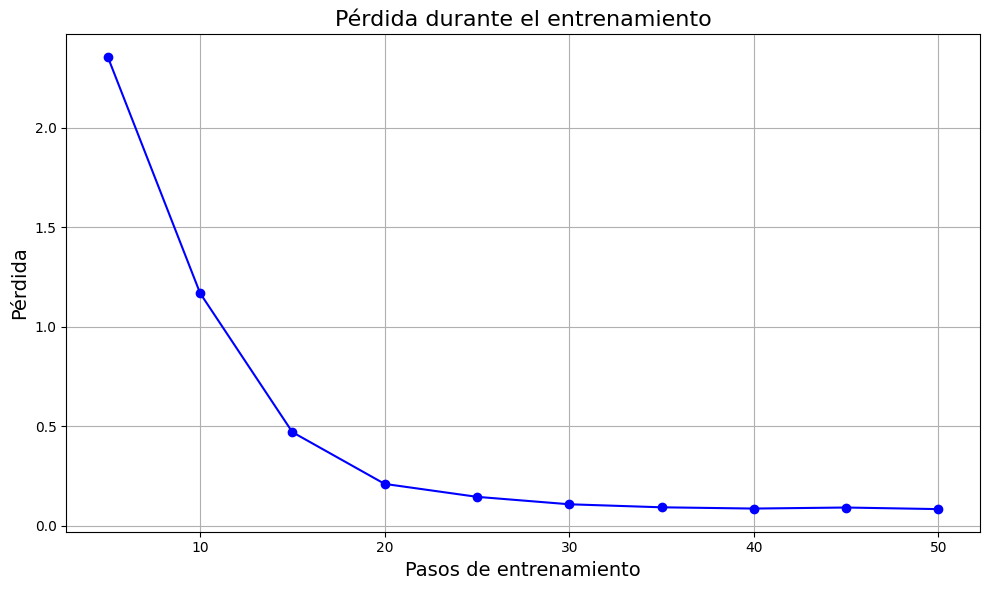

Guardando modelo y tokenizador...
Modelo guardado en './idioma4_phi2_lora'


In [2]:
# 5. ENTRENAMIENTO
# Configuramos los argumentos de entrenamiento para un entrenamiento rápido inicial
print("Configurando parámetros de entrenamiento...")
training_args = TrainingArguments(
    output_dir="./results_idioma4_phi2",
    # Configuración para entrenamiento rápido
    per_device_train_batch_size=8,         # Tamaño de batch más grande para velocidad
                                          # Para entrenamiento profundo: reducir a 2-4

    gradient_accumulation_steps=2,        # Menos pasos de acumulación para velocidad
                                          # Para entrenamiento profundo: aumentar a 8-16

    warmup_steps=5,                       # Menos pasos de calentamiento
                                          # Para entrenamiento profundo: aumentar a 50-100

    max_steps=50,                         # Menos pasos totales para prueba rápida
                                          # Para entrenamiento profundo: aumentar a 500-1000

    learning_rate=3e-4,                   # Learning rate más alto para convergencia rápida
                                          # Para entrenamiento profundo: reducir a 1e-4 o 5e-5

    fp16=True,                            # Usar precisión mixta para acelerar el entrenamiento

    logging_steps=5,                      # Registro frecuente para ver progreso

    save_steps=5,                         # Guardar checkpoints
                                          # Para entrenamiento profundo: cada 100-200 pasos

    save_total_limit=2,                   # Mantener menos checkpoints para ahorrar espacio

    report_to="none",                     # No enviar métricas a servicios externos

    # Parámetros adicionales para entrenamiento más estable
    # Descomentar para entrenamiento profundo:
    # weight_decay=0.01,                  # Regularización L2 para evitar sobreajuste
    # lr_scheduler_type="cosine",         # Programación de tasa de aprendizaje tipo coseno
    # max_grad_norm=1.0,                  # Recorte de gradiente para estabilidad
)

# Creamos un callback personalizado para registrar las pérdidas durante el entrenamiento
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.steps, self.losses, marker='o', linestyle='-', color='blue')
        plt.title('Pérdida durante el entrenamiento', fontsize=16)
        plt.xlabel('Pasos de entrenamiento', fontsize=14)
        plt.ylabel('Pérdida', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('loss_plot.png')  # Guardar la gráfica como imagen
        plt.show()

# Instanciamos el callback
loss_callback = LossCallback()

# Collator de datos para el entrenamiento
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # No es masked language modeling, sino causal
)

# Inicializamos el Trainer con nuestro callback
print("Inicializando Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    callbacks=[loss_callback]  # Añadimos nuestro callback para registrar las pérdidas
)

# Entrenamos el modelo
print("Comenzando entrenamiento...")
trainer.train()
print("Entrenamiento completado.")

# Graficamos la pérdida
print("Generando gráfica de pérdida...")
loss_callback.plot_loss()

# 6. GUARDADO DEL MODELO
# Guardamos el modelo adaptado con LoRA
print("Guardando modelo y tokenizador...")
model.save_pretrained("./idioma4_phi2_lora")
tokenizer.save_pretrained("./idioma4_phi2_lora")
print("Modelo guardado en './idioma4_phi2_lora'")



In [4]:
# 7. INFERENCIA CON GRADIO

import gradio as gr

def generate_idioma4(input_text, max_length=200):
    """Traduce texto al idioma 4 usando el modelo fine-tuneado."""
    # Manejamos el caso de texto vacío
    if not input_text.strip():
        return "Por favor ingresa algún texto para traducir."

    # Preparamos el prompt según el formato usado en entrenamiento
    prompt = f"<s>Traduce este texto al idioma 4: {input_text}\n\n"

    # Tokenizamos
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generamos la respuesta
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            temperature=0.7,        # Controla la aleatoriedad (más bajo = más determinista)
            top_p=0.9,              # Muestreo nucleus - considera tokens con probabilidad acumulada de 0.9
            do_sample=True,         # Muestreo probabilístico en lugar de greedy decoding
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decodificamos la respuesta
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraemos solo la parte de respuesta (después del doble salto de línea)
    if "\n\n" in generated_text:
        response = generated_text.split("\n\n")[1].strip()
    else:
        response = generated_text.replace(prompt, "").strip()

    return response

# Creamos la interfaz con Gradio
def create_gradio_interface():
    """Crea y lanza una interfaz Gradio para la traducción al idioma 4."""

    # Definimos la interfaz
    demo = gr.Interface(
        fn=generate_idioma4,              # Función que procesa la entrada
        inputs=[
            gr.Textbox(
                placeholder="Escribe texto para traducir al idioma 4...",
                label="Texto Original",
                lines=5
            )
        ],
        outputs=[
            gr.Textbox(label="Traducción al Idioma 4", lines=5)
        ],
        title="Traductor al Idioma 4",
        description="""
        <h3>¡Bienvenido al Traductor de Idioma 4!</h3>
        <p>Este es un modelo de lenguaje fine-tuneado con PEFT-LoRA para traducir texto al "idioma 4",
        donde cada letra 'a' se reemplaza por el número '4'.</p>
        <p><b>Ejemplo:</b> "La casa amarilla" → "L4 c4s4 4m4rill4"</p>
        """,
        examples=[
            ["Hola a todos, me llamo Camilo"],
            ["La casa amarilla está en la playa"],
            ["Vamos a aprender inteligencia artificial"],
            ["El agua clara cae desde la alta cascada"]
        ],
        theme=gr.themes.Soft()  # Tema visual más atractivo
    )

    # Lanzamos la interfaz
    demo.launch(share=True)  # share=True crea un enlace compartible
    return demo

# Lanzamos la interfaz Gradio
print("Iniciando interfaz Gradio para el traductor de Idioma 4...")
interface = create_gradio_interface()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00
Iniciando interfaz Gradio para el traductor de Idioma 4...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a6950d73843d503259.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
